In [60]:
import sys
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    roc_auc_score, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    roc_curve, 
    roc_auc_score
)

In [61]:
df1 = pd.read_csv("f1_2022_2023_train.csv")
df2 = pd.read_csv("f1_2024_test.csv")

# Stack them vertically
df = pd.concat([df1, df2], axis=0)

print(f"Base data has {df.shape[0]} rows and {df.shape[1]} columns")
df.head()

Base data has 1017 rows and 59 columns


,Driver.code,air_temp_mid,avg_lap_time,avg_tyre_life,constructor,driver,driverId,finishing_position,grid_position,humidity_mid,...,Q2_sec,Q3_sec,Q1_sec_filled,Q2_sec_filled,Q3_sec_filled,Q1_gap,Q2_gap,Q3_gap,flg_podium,flg_top5
0,ALB,23.2,101.569843,19.00,Williams,ALB,albon,13.0,14.0,37,...,92.664,NaN,92.726,92.664,113.841,27.610,27.713,49.450,0,0
1,ALO,23.2,102.109941,14.25,Alpine,ALO,alonso,9.0,8.0,37,...,91.621,92.195,92.346,91.621,92.195,27.230,26.670,27.804,0,0
2,BOT,23.2,101.061882,19.00,Alfa Romeo,BOT,bottas,6.0,6.0,37,...,91.717,91.560,91.919,91.717,91.560,26.803,26.766,27.169,0,0
3,GAS,23.2,99.646250,15.00,AlphaTauri,GAS,gasly,20.0,10.0,37,...,91.635,92.338,92.096,91.635,92.338,26.980,26.684,27.947,0,0
4,HAM,23.2,101.586803,14.25,Mercedes,HAM,hamilton,3.0,5.0,37,...,91.048,91.238,92.285,91.048,91.238,27.169,26.097,26.847,1,1


In [62]:
# select features
#   a) keep all non-target columns, or
#   b) explicitly list the ones we want.

feature_cols = ['Q1_gap', 'pitted', 
                'weather_precip_total', 'weather_airTemp_mean', 
                'qualifying_round_reached', 
                'humidity_mid', 'pit_min_duration_sec', 
                'lapTime_std_sec', 'Q2_sec_filled', 'race_name', 
                'pit_avg_duration_sec', 'weather_wind_mean', 
                'Q3_gap', 'pit_last_lap', 'Q3_sec_filled', 
                'weather_humidity_mean', 'multi_stop', 
                'track_temp_mid', 'avg_tyre_life', 'Q2_gap', 
                'weather_pressure_mean', 'pit_total_duration_sec', 
                'avg_lap_time', 'grid_position', 'made_Q3', 
                'laps_count', 'made_Q2', 'air_temp_mid', 
                'one_stop', 'weather_airTemp_max', 
                'lapTime_best_sec', 'lapTime_mean_sec', 
                'qualiPosition', 'pit_first_lap', 
                'eliminated_in_Q3', 'eliminated_in_Q2', 
                'eliminated_in_Q1', 'flg_podium', 'laps_total', 
                'num_pit_stops', 'Q1_sec_filled', 'round', 'weather_airTemp_min']


In [63]:
# keep only existing columns to avoid key errors
feature_cols = [c for c in feature_cols if c in df.columns]

In [64]:
ml_dataset = df[feature_cols].copy()
print(f"Working dataset has {ml_dataset.shape[0]} rows and {ml_dataset.shape[1]} columns")

Working dataset has 1017 rows and 43 columns


In [65]:
# coerce types and preprocessing
def coerce_to_unicode(x):
    if sys.version_info < (3, 0):
        if isinstance(x, str):
            return unicode(x, "utf-8")
        else:
            return unicode(x)
    else:
        return str(x)

# split into cats / nums like in DSS
categorical_features = [
    "pitted", "race_name", "multi_stop",
    "grid_position_group",
    "driver", "team",
    "eliminated_in_Q3", "eliminated_in_Q2", "eliminated_in_Q1",
]
categorical_features = [c for c in categorical_features if c in ml_dataset.columns]

numerical_features = [c for c in feature_cols if c not in categorical_features]


In [66]:
# cast types
for feat in categorical_features:
    ml_dataset[feat] = ml_dataset[feat].apply(coerce_to_unicode)

for feat in numerical_features:
    ml_dataset[feat] = ml_dataset[feat].astype("float64")

In [67]:
# stratified train/test split (80/20)
train, test = train_test_split(
    ml_dataset,
    test_size=0.2,
    random_state=1337,
    stratify=ml_dataset["flg_podium"]
)

print(f"Train data: {train.shape}")
print(f"Test  data: {test.shape}")

Train data: (813, 43)
Test  data: (204, 43)


In [68]:
X_train = train.drop(columns=["flg_podium"])
X_test  = test.drop(columns=["flg_podium"])

y_train = train["flg_podium"].astype(int).to_numpy().ravel()
y_test  = test["flg_podium"].astype(int).to_numpy().ravel()

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test :", X_test.shape)
print("y_test :", y_test.shape)

X_train: (813, 42)
y_train: (813,)
X_test : (204, 42)
y_test : (204,)


In [69]:
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(
    include=["object", "category", "bool"]
).columns.tolist()

print("Numeric features:", len(numeric_features))
print("Categorical features:", len(categorical_features))

Numeric features: 36
Categorical features: 6


In [70]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", max_categories=100))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [128]:
models = {}

# L1 Logistic Regression (similar to what you had in Dataiku)
models["logit_l1"] = LogisticRegression(
    penalty="l1",
    solver="liblinear",
    class_weight="balanced",
    random_state=1337,
    max_iter=1000
)

# Random Forest
models["rf"] = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight="balanced",
    random_state=1337,
    n_jobs=-1
)

# XGBoost (if available)
models["xgb"] = XGBClassifier(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    random_state=1337
)

# MLP classifier (NN)
models["mlp"] = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    solver="adam",
    alpha=1e-4,
    max_iter=300,
    random_state=1337
)


In [130]:
# decision rule: optimize F1-Score

def optimal_threshold_f1(y_true, y_score, n_grid=99):
    """
    Search over thresholds in (0,1) and return the one that maximizes F1.
    y_score = predicted probabilities for the positive class.
    """
    thresholds = np.linspace(0.01, 0.99, n_grid)
    best_thr = 0.5
    best_f1 = -1.0

    for thr in thresholds:
        y_pred_thr = (y_score >= thr).astype(int)
        f1 = f1_score(y_true, y_pred_thr, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_thr = thr

    return best_thr, best_f1

In [131]:
results = []
best_thresholds = {}   # store best threshold per model

for name, clf in models.items():
    print(f"Training model: {name}")
    
    pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("clf", clf)
    ])
    
    pipe.fit(X_train, y_train)
    
    # --- probabilities ---
    y_proba = None
    auc = np.nan
    f1_opt = np.nan
    thr_opt = 0.5
    
    if hasattr(pipe.named_steps["clf"], "predict_proba"):
        # True probabilities
        y_proba = pipe.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)

        # get F1-optimal threshold
        thr_opt, f1_opt = optimal_threshold_f1(y_test, y_proba)
        best_thresholds[name] = thr_opt

        # use that threshold for predictions
        y_pred = (y_proba >= thr_opt).astype(int)

    elif hasattr(pipe.named_steps["clf"], "decision_function"):
        # Scores (not probs) – still OK for AUC, but we can’t interpret as probability
        scores = pipe.decision_function(X_test)
        auc = roc_auc_score(y_test, scores)

        # We *could* optimize threshold on scores as well:
        thr_opt, f1_opt = optimal_threshold_f1(y_test, scores)
        best_thresholds[name] = thr_opt
        y_pred = (scores >= thr_opt).astype(int)
    else:
        # No scores available: fall back to plain predict (rare case)
        y_pred = pipe.predict(X_test)
    
    # --- metrics using the chosen threshold ---
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    
    # if we computed f1_opt, use it; otherwise compute directly
    if np.isnan(f1_opt):
        f1_opt = f1_score(y_test, y_pred, zero_division=0)
    
    results.append({
        "model": name,
        "threshold_F1_opt": thr_opt,
        "ROC_AUC": auc,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "F1": f1_opt
    })

results_df = pd.DataFrame(results).sort_values(by="ROC_AUC", ascending=False)
results_df

Training model: logit_l1
Training model: rf
Training model: xgb
Training model: mlp


,model,threshold_F1_opt,ROC_AUC,accuracy,precision,recall,F1
0,logit_l1,0.72,0.938094,0.916667,0.694444,0.806452,0.746269
2,xgb,0.26,0.921126,0.916667,0.733333,0.709677,0.721311
1,rf,0.43,0.916931,0.916667,0.769231,0.645161,0.701754
3,mlp,0.46,0.898937,0.911765,0.724138,0.677419,0.700000


The chosen model then is logit.

In [132]:
from sklearn.calibration import CalibratedClassifierCV

logit_l1 = LogisticRegression(
    penalty="l1",
    solver="liblinear",
    class_weight="balanced",
    random_state=1337,
    max_iter=1000
)

base_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", logit_l1)
])

calibrated_logit = CalibratedClassifierCV(
    estimator=base_pipe,
    cv=5,
    method="sigmoid"
)

calibrated_logit.fit(X_train, y_train)

# Probabilities on test set
y_proba = calibrated_logit.predict_proba(X_test)[:, 1]

# Find F1-optimal threshold for *this* final model
best_thr_logit, best_f1_logit = optimal_threshold_f1(y_test, y_proba)
print(f"Best F1 threshold for calibrated logit: {best_thr_logit:.3f}")
print(f"Best F1 score: {best_f1_logit:.3f}")

# Use this threshold for labels
y_pred = (y_proba >= best_thr_logit).astype(int)

print("ROC–AUC :", roc_auc_score(y_test, y_proba))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, zero_division=0))
print("Recall   :", recall_score(y_test, y_pred, zero_division=0))
print("F1       :", best_f1_logit)

Best F1 threshold for calibrated logit: 0.320
Best F1 score: 0.746
ROC–AUC : 0.9386537385791535
Accuracy: 0.9166666666666666
Precision: 0.6944444444444444
Recall   : 0.8064516129032258
F1       : 0.746268656716418


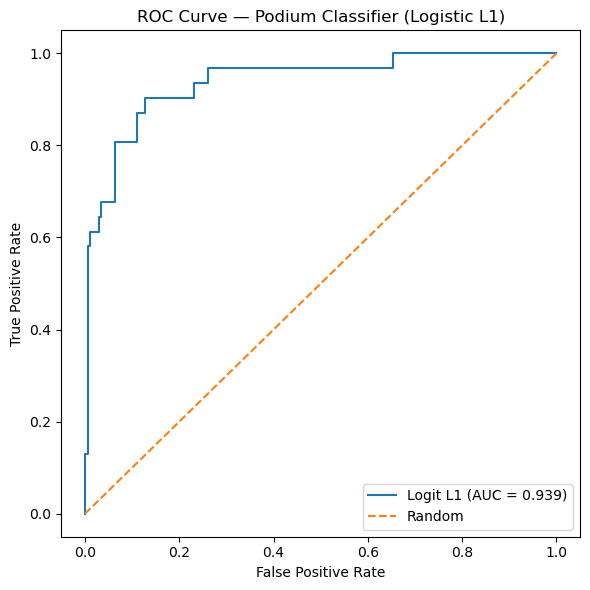

ROC–AUC: 0.9386537385791535


In [74]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"Logit L1 (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Podium Classifier (Logistic L1)")
plt.legend()
plt.tight_layout()
plt.show()

print("ROC–AUC:", auc)

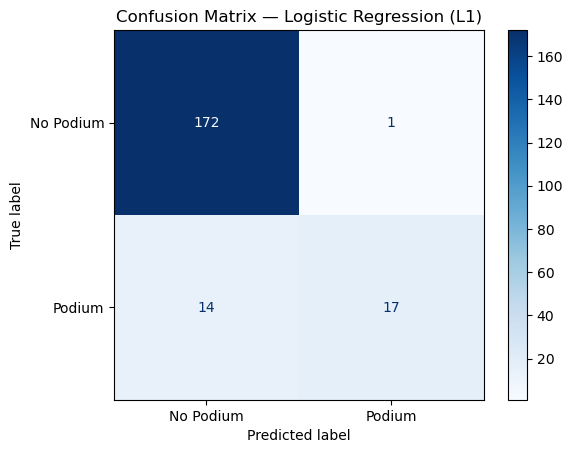

In [75]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=[0,1])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Podium", "Podium"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix — Logistic Regression (L1)")
plt.show()

In [76]:
# Build a small evaluation dataframe
eval_df = pd.DataFrame({
    "y": y_test,
    "score": y_proba
})

# Sort by predicted probability descending
eval_df = eval_df.sort_values("score", ascending=False).reset_index(drop=True)

# Overall podium rate (baseline)
base_rate = eval_df["y"].mean()
print(f"Baseline podium rate in test set: {base_rate:.3%}")

Baseline podium rate in test set: 15.196%


In [77]:
top_frac = 0.10
n_top = int(len(eval_df) * top_frac)

top_df = eval_df.iloc[:n_top]
top_rate = top_df["y"].mean()
lift_top10 = top_rate / base_rate

print(f"Podium rate in top 10% highest scores: {top_rate:.3%}")
print(f"Lift at top 10%: {lift_top10:.2f}x baseline")

Podium rate in top 10% highest scores: 90.000%
Lift at top 10%: 5.92x baseline


In [78]:
# Create deciles based on rank
eval_df["decile"] = pd.qcut(
    eval_df.index,
    q=10,
    labels=False
)  # 0 = top 10%, 9 = bottom 10%

lift_table = (
    eval_df.groupby("decile")
           .agg(
               n=("y", "size"),
               podiums=("y", "sum"),
               response_rate=("y", "mean"),
               avg_score=("score", "mean")
           )
           .sort_index()
)

lift_table["lift"] = lift_table["response_rate"] / base_rate
lift_table

,n,podiums,response_rate,avg_score,lift
decile,,,,,
0,21,19,0.904762,0.611687,5.953917
1,20,6,0.300000,0.378730,1.974194
2,20,3,0.150000,0.170632,0.987097
3,21,2,0.095238,0.110832,0.626728
4,20,0,0.000000,0.063758,0.000000
5,20,0,0.000000,0.035873,0.000000
6,21,0,0.000000,0.018509,0.000000
7,20,1,0.050000,0.006028,0.329032
8,20,0,0.000000,0.001872,0.000000


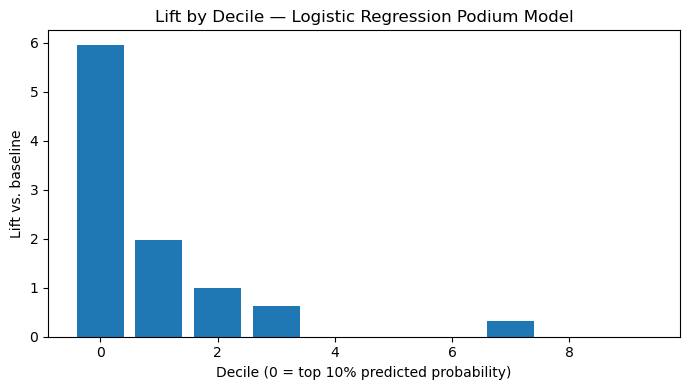

In [79]:
plt.figure(figsize=(7, 4))
plt.bar(lift_table.index, lift_table["lift"])
plt.xlabel("Decile (0 = top 10% predicted probability)")
plt.ylabel("Lift vs. baseline")
plt.title("Lift by Decile — Logistic Regression Podium Model")
plt.tight_layout()
plt.show()

In [80]:
def get_feature_names(preprocessor):
    """Extract final feature names from column transformer."""
    output_features = []

    for name, transformer, cols in preprocessor.transformers_:

        if name == "drop":
            continue

        if hasattr(transformer, "get_feature_names_out"):
            fts = list(transformer.get_feature_names_out(cols))
            output_features.extend(fts)

        elif hasattr(transformer, "named_steps"):
            # For pipelines inside ColumnTransformer
            inner = transformer.named_steps.get("onehot") or transformer.named_steps.get("scaler")
            if inner and hasattr(inner, "get_feature_names_out"):
                fts = list(inner.get_feature_names_out(cols))
                output_features.extend(fts)
            else:
                output_features.extend(cols)

        else:
            output_features.extend(cols)

    return output_features

In [81]:
# ----- Refit the chosen podium model (logit_l1) in the pipeline -----
base_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(
        penalty="l1",
        solver="liblinear",
        class_weight="balanced",
        random_state=1337,
        max_iter=1000
    ))
])

base_pipe.fit(X_train, y_train)

# ----- Get feature names after preprocessing -----
preprocess_fitted = base_pipe.named_steps["preprocess"]
feature_names = get_feature_names(preprocess_fitted)

# ----- Extract and rank coefficient-based importances -----
logit = base_pipe.named_steps["clf"]
coefs = logit.coef_.ravel()          # shape (n_features,)

feat_imp = (
    pd.DataFrame({
        "feature": feature_names,
        "coef": coefs,
        "abs_coef": np.abs(coefs)
    })
    .sort_values("abs_coef", ascending=False)
)

# Look at the top 10 most important features
feat_imp.head(10)

,feature,coef,abs_coef
23,made_Q2,3.334622,3.334622
7,Q2_sec_filled,3.280905,3.280905
29,qualiPosition,-1.840837,1.840837
20,grid_position,-1.673114,1.673114
66,eliminated_in_Q2_False,-1.562819,1.562819
33,Q1_sec_filled,-1.097826,1.097826
19,avg_lap_time,-0.867885,0.867885
59,race_name_Spanish Grand Prix,0.717762,0.717762
18,pit_total_duration_sec,-0.632351,0.632351
38,race_name_Abu Dhabi Grand Prix,-0.604872,0.604872


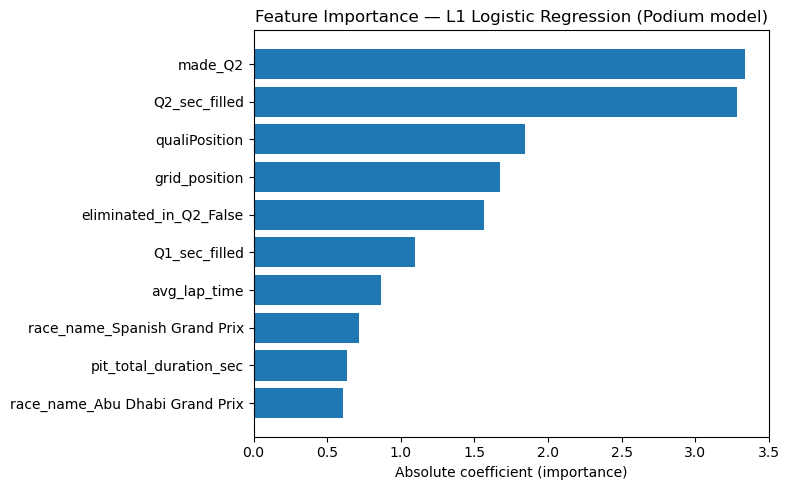

In [82]:
top_n = 10
top_imp = feat_imp.head(top_n).iloc[::-1]   

plt.figure(figsize=(8, 5))
plt.barh(top_imp["feature"], top_imp["abs_coef"])
plt.xlabel("Absolute coefficient (importance)")
plt.title("Feature Importance — L1 Logistic Regression (Podium model)")
plt.tight_layout()
plt.show()

## Simulations

In [87]:
# Build representative row using:
# - mean for numeric features
# - mode for categorical features

num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X_train.select_dtypes(include=["object", "bool", "category"]).columns

avg_row = {}

for col in num_cols:
    avg_row[col] = X_train[col].mean()

for col in cat_cols:
    avg_row[col] = X_train[col].mode()[0]

avg_row = pd.DataFrame([avg_row])

print("Average row constructed with shape:", avg_row.shape)

Average row constructed with shape: (1, 42)


In [84]:
# Min/max values from full dataset
wind_min  = df["weather_wind_mean"].min()
wind_max  = df["weather_wind_mean"].max()

temp_min  = df["track_temp_mid"].min()
temp_max  = df["track_temp_mid"].max()

press_min = df["weather_pressure_mean"].min()
press_max = df["weather_pressure_mean"].max()

precip_min = df["weather_precip_total"].min()
precip_max = df["weather_precip_total"].max()

In [90]:
scenarios = []

def scenario(name, **changes):
    s = avg_row.copy()
    for col, val in changes.items():
        if col in s.columns:
            s[col] = val
    s["scenario"] = name
    return s

scenarios = pd.concat([
    scenario("baseline"),

    scenario("wind_min",  weather_wind_mean=wind_min),
    scenario("wind_max",  weather_wind_mean=wind_max),

    scenario("temp_min",  track_temp_mid=temp_min),
    scenario("temp_max",  track_temp_mid=temp_max),

    scenario("press_min", weather_pressure_mean=press_min),
    scenario("press_max", weather_pressure_mean=press_max),

    scenario("precip_min", weather_precip_total=precip_min),
    scenario("precip_max", weather_precip_total=precip_max),
], ignore_index=True)

scenarios

,Q1_gap,weather_precip_total,weather_airTemp_mean,qualifying_round_reached,humidity_mid,pit_min_duration_sec,lapTime_std_sec,Q2_sec_filled,pit_avg_duration_sec,weather_wind_mean,...,Q1_sec_filled,round,weather_airTemp_min,pitted,race_name,multi_stop,eliminated_in_Q3,eliminated_in_Q2,eliminated_in_Q1,scenario
0,21.129075,1.925338,20.384543,2.260763,52.157442,25.921576,45.917498,95.151429,26.671514,12.022622,...,86.312699,10.99139,16.097417,True,Miami Grand Prix,True,True,False,False,baseline
1,21.129075,1.925338,20.384543,2.260763,52.157442,25.921576,45.917498,95.151429,26.671514,4.666667,...,86.312699,10.99139,16.097417,True,Miami Grand Prix,True,True,False,False,wind_min
2,21.129075,1.925338,20.384543,2.260763,52.157442,25.921576,45.917498,95.151429,26.671514,25.200000,...,86.312699,10.99139,16.097417,True,Miami Grand Prix,True,True,False,False,wind_max
3,21.129075,1.925338,20.384543,2.260763,52.157442,25.921576,45.917498,95.151429,26.671514,12.022622,...,86.312699,10.99139,16.097417,True,Miami Grand Prix,True,True,False,False,temp_min
4,21.129075,1.925338,20.384543,2.260763,52.157442,25.921576,45.917498,95.151429,26.671514,12.022622,...,86.312699,10.99139,16.097417,True,Miami Grand Prix,True,True,False,False,temp_max
5,21.129075,1.925338,20.384543,2.260763,52.157442,25.921576,45.917498,95.151429,26.671514,12.022622,...,86.312699,10.99139,16.097417,True,Miami Grand Prix,True,True,False,False,press_min
6,21.129075,1.925338,20.384543,2.260763,52.157442,25.921576,45.917498,95.151429,26.671514,12.022622,...,86.312699,10.99139,16.097417,True,Miami Grand Prix,True,True,False,False,press_max
7,21.129075,0.000000,20.384543,2.260763,52.157442,25.921576,45.917498,95.151429,26.671514,12.022622,...,86.312699,10.99139,16.097417,True,Miami Grand Prix,True,True,False,False,precip_min
8,21.129075,19.100000,20.384543,2.260763,52.157442,25.921576,45.917498,95.151429,26.671514,12.022622,...,86.312699,10.99139,16.097417,True,Miami Grand Prix,True,True,False,False,precip_max


In [91]:
X_scenarios = scenarios.drop(columns=["scenario"], errors="ignore")

probas = calibrated_logit.predict_proba(X_scenarios)[:, 1]
scenarios["proba_podium"] = probas
scenarios["proba_pct"] = (probas * 100).round(2)

scenarios[["scenario", "proba_pct"]]

,scenario,proba_pct
0,baseline,4.14
1,wind_min,3.86
2,wind_max,4.76
3,temp_min,5.63
4,temp_max,3.38
5,press_min,6.68
6,press_max,3.04
7,precip_min,4.22
8,precip_max,3.65


In [92]:

def plot_probability_gauge(prob, threshold=0.325, title=""):
    """
    prob: probability of podium (0–1)
    threshold: classification threshold for reference
    """

    p1 = prob * 100
    p0 = 100 - p1

    fig, ax = plt.subplots(figsize=(10, 1.6))

    # Draw stacked bar
    ax.barh(0, p1, color="#f28e2b", edgecolor="none", label=f"Podium: {p1:.2f}%")
    ax.barh(0, p0, left=p1, color="#4e79a7", edgecolor="none", label=f"No Podium: {p0:.2f}%")

    # Threshold line
    ax.axvline(threshold * 100, color="black", linewidth=1, label=f"Threshold: {threshold*100:.1f}%")

    # Styling
    ax.set_xlim(0, 100)
    ax.set_yticks([])
    ax.set_xlabel("Predicted Probability (%)")
    ax.set_title(title or f"Probability for Podium: {p1:.2f}%")

    ax.legend(loc="upper right", fontsize=8)
    plt.tight_layout()
    plt.show()

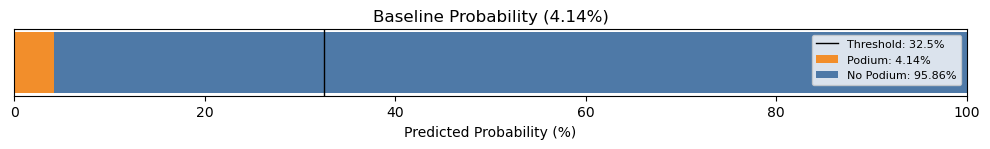

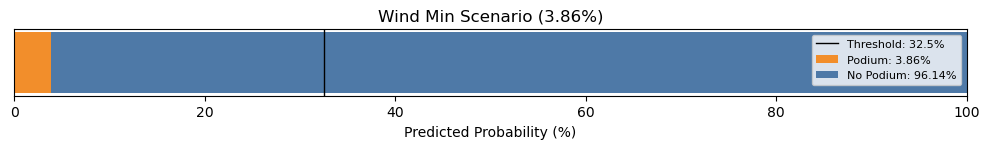

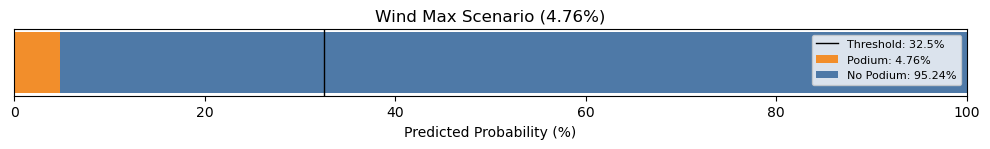

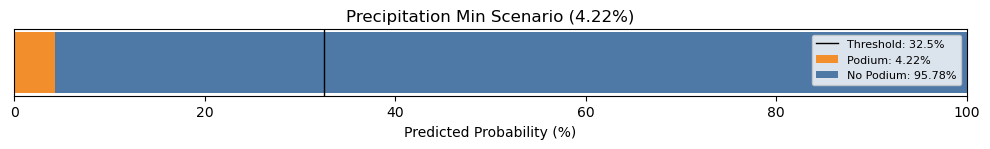

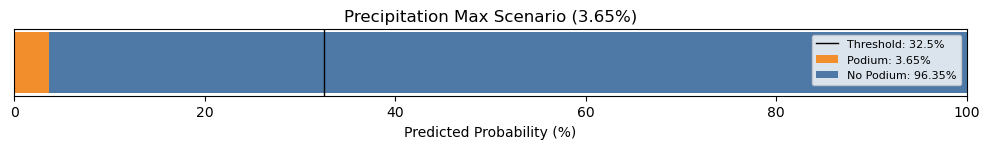

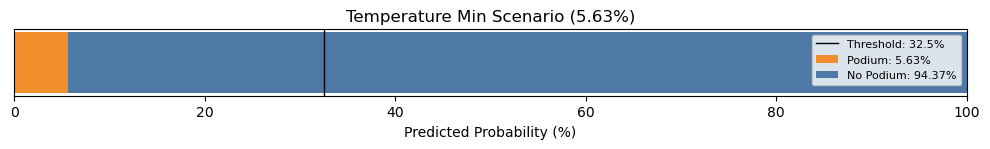

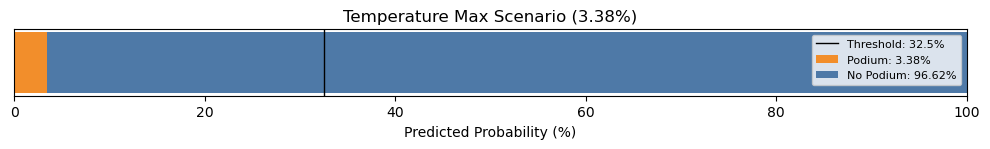

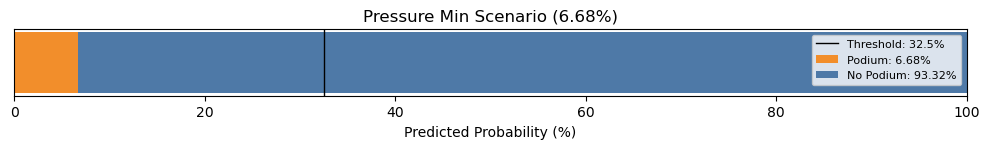

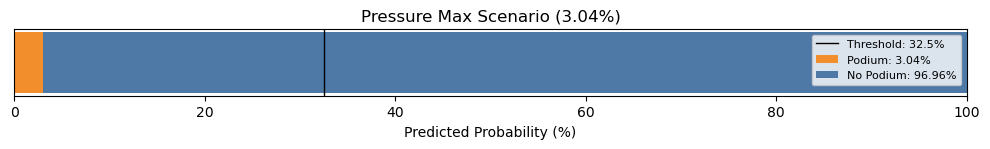

In [94]:
plot_probability_gauge(0.0414, title="Baseline Probability (4.14%)")

plot_probability_gauge(0.0386, title="Wind Min Scenario (3.86%)")
plot_probability_gauge(0.0476, title="Wind Max Scenario (4.76%)")

plot_probability_gauge(0.0422, title="Precipitation Min Scenario (4.22%)")
plot_probability_gauge(0.0365, title="Precipitation Max Scenario (3.65%)")

plot_probability_gauge(0.0563, title="Temperature Min Scenario (5.63%)")
plot_probability_gauge(0.0338, title="Temperature Max Scenario (3.38%)")

plot_probability_gauge(0.0668, title="Pressure Min Scenario (6.68%)")
plot_probability_gauge(0.0304, title="Pressure Max Scenario (3.04%)")

#### Particular drivers simulation

In [104]:
top_drivers = ["VER", "PER", "LEC", "NOR"]        
race_filter = (df['year'] == 2024) & (df['race_name'] == "Australian Grand Prix")

# columns used as inputs for the model
X_cols = [c for c in df.columns if c != 'flg_podium']
# --------------------------------

# subset to the race you want to simulate on
race_df = df.loc[race_filter].copy()

print("Rows in race_df:", race_df.shape)
race_df[['driver', 'race_name']].head()

Rows in race_df: (19, 59)


,driver,race_name
40,SAI,Australian Grand Prix
41,LEC,Australian Grand Prix
42,NOR,Australian Grand Prix
43,PIA,Australian Grand Prix
44,PER,Australian Grand Prix


In [108]:
wind_min   = df["weather_wind_mean"].min()
wind_max   = df["weather_wind_mean"].max()
temp_min   = df["track_temp_mid"].min()
temp_max   = df["track_temp_mid"].max()
press_min  = df["weather_pressure_mean"].min()
press_max  = df["weather_pressure_mean"].max()
precip_min = df["weather_precip_total"].min()
precip_max = df["weather_precip_total"].max()

In [109]:
def predict_podium_proba(model, X_row: pd.DataFrame) -> float:
    """Return podium probability for a 1-row DataFrame."""
    proba = model.predict_proba(X_row[X_cols])[:, 1][0]
    return float(proba)

In [112]:
rows = []

for drv in top_drivers:
    # pick that driver's row for this race
    row = race_df.loc[race_df['driver'] == drv]
    if row.empty:
        print(f"Warning: no row found for {drv} in this race; skipping.")
        continue
    
    row = row.iloc[[0]]  # keep it as DataFrame with 1 row

    # Baseline
    baseline = predict_podium_proba(calibrated_logit, row)

    # Wind scenarios
    row_wind_min = row.copy()
    row_wind_min['weather_wind_mean'] = wind_min
    wind_min_p = predict_podium_proba(calibrated_logit, row_wind_min)

    row_wind_max = row.copy()
    row_wind_max['weather_wind_mean'] = wind_max
    wind_max_p = predict_podium_proba(calibrated_logit, row_wind_max)

    # Track temperature scenarios
    row_temp_min = row.copy()
    row_temp_min['track_temp_mid'] = temp_min
    temp_min_p = predict_podium_proba(calibrated_logit, row_temp_min)

    row_temp_max = row.copy()
    row_temp_max['track_temp_mid'] = temp_max
    temp_max_p = predict_podium_proba(calibrated_logit, row_temp_max)

    # Pressure scenarios
    row_press_min = row.copy()
    row_press_min['weather_pressure_mean'] = press_min
    press_min_p = predict_podium_proba(calibrated_logit, row_press_min)

    row_press_max = row.copy()
    row_press_max['weather_pressure_mean'] = press_max
    press_max_p = predict_podium_proba(calibrated_logit, row_press_max)

    # Precipitation scenarios
    row_precip_min = row.copy()
    row_precip_min['weather_precip_total'] = precip_min
    precip_min_p = predict_podium_proba(calibrated_logit, row_precip_min)

    row_precip_max = row.copy()
    row_precip_max['weather_precip_total'] = precip_max
    precip_max_p = predict_podium_proba(calibrated_logit, row_precip_max)

    rows.append({
        "Driver": drv,
        "Baseline":      baseline,
        "Min Wind":      wind_min_p,
        "Max Wind":      wind_max_p,
        "Min Track Temp": temp_min_p,
        "Max Track Temp": temp_max_p,
        "Min Pressure":   press_min_p,
        "Max Pressure":   press_max_p,
        "Min Precip.":    precip_min_p,
        "Max Precip.":    precip_max_p,
    })

driver_scenarios_df = pd.DataFrame(rows)

In [119]:
# probabilities as decimals with 4 digits (like your screenshot)
table = (driver_scenarios_df
         .set_index("Driver")
         .map(lambda x: round(x, 4)))

table

,Baseline,Min Wind,Max Wind,Min Track Temp,Max Track Temp,Min Pressure,Max Pressure,Min Precip.,Max Precip.
Driver,,,,,,,,,
VER,0.3331,0.3181,0.3509,0.3998,0.3046,0.5180,0.3029,0.3331,0.3134
PER,0.6777,0.6632,0.6936,0.7378,0.6449,0.8195,0.6428,0.6777,0.6603
LEC,0.6711,0.6581,0.6848,0.7301,0.6388,0.8197,0.6354,0.6711,0.6575
NOR,0.7630,0.7521,0.7742,0.8101,0.7355,0.8757,0.7332,0.7630,0.7496


In [124]:
# columns where we want deltas relative to baseline
table = table.reset_index()

scenario_cols = [
    "Min Wind", "Max Wind",
    "Min Track Temp", "Max Track Temp",
    "Min Pressure", "Max Pressure",
    "Min Precip.", "Max Precip."
]

baseline_col = "Baseline"

# make a copy for deltas
df_delta = table[["Driver", baseline_col]].copy()

# absolute change (scenario - baseline)
for col in scenario_cols:
    delta_col = col + " Δ"
    df_delta[delta_col] = table[col] - table[baseline_col]

# round for readability
df_delta_rounded = df_delta.copy()
for c in df_delta_rounded.columns:
    if c != "Driver":
        df_delta_rounded[c] = df_delta_rounded[c].round(4)

df_delta_rounded

,Driver,Baseline,Min Wind Δ,Max Wind Δ,Min Track Temp Δ,Max Track Temp Δ,Min Pressure Δ,Max Pressure Δ,Min Precip. Δ,Max Precip. Δ
0,VER,0.3331,-0.0150,0.0178,0.0667,-0.0285,0.1849,-0.0302,0.0,-0.0197
1,PER,0.6777,-0.0145,0.0159,0.0601,-0.0328,0.1418,-0.0349,0.0,-0.0174
2,LEC,0.6711,-0.0130,0.0137,0.0590,-0.0323,0.1486,-0.0357,0.0,-0.0136
3,NOR,0.7630,-0.0109,0.0112,0.0471,-0.0275,0.1127,-0.0298,0.0,-0.0134


## Predictions for Australia Grand Prix (2025)

In [125]:
# Load 2025 feature data
pred_2025_path = "f1_2025_pred.csv"   
df_2025 = pd.read_csv(pred_2025_path)

print(df_2025.shape)
df_2025.head()

(438, 55)


,season,year,round,race_name,driver,driverId,constructor,grid_position,num_pit_stops,avg_lap_time,...,Q1_sec,Q2_sec,Q3_sec,session_type,Q1_sec_filled,Q2_sec_filled,Q3_sec_filled,Q1_gap,Q2_gap,Q3_gap
0,2025,2025,1,Australian Grand Prix,NOR,norris,McLaren,1.0,5,101.882020,...,75.912,75.415,75.096,race,75.912,75.415,75.096,11.240,11.005,11.125
1,2025,2025,1,Australian Grand Prix,VER,max_verstappen,Red Bull Racing,3.0,5,100.844729,...,76.018,75.565,75.481,race,76.018,75.565,75.481,11.346,11.155,11.510
2,2025,2025,1,Australian Grand Prix,RUS,russell,Mercedes,4.0,5,101.866604,...,75.971,75.798,75.546,race,75.971,75.798,75.546,11.299,11.388,11.575
3,2025,2025,1,Australian Grand Prix,ANT,antonelli,Mercedes,16.0,5,103.041285,...,76.525,NaN,NaN,race,76.525,118.683,116.540,11.853,54.273,52.569
4,2025,2025,1,Australian Grand Prix,ALB,albon,Williams,6.0,5,103.074816,...,76.245,76.017,75.737,race,76.245,76.017,75.737,11.573,11.607,11.766


In [126]:
# Keep only columns that actually exist in this file
feat_2025_cols = [c for c in feature_cols if c in df_2025.columns]

X_2025 = df_2025[feat_2025_cols].copy()

# If flg_podium is present in 2025 data, drop it (no cheating)
if "flg_podium" in X_2025.columns:
    X_2025 = X_2025.drop(columns=["flg_podium"])

# Filter to Australian Grand Prix 2025
mask_aus = (df_2025["race_name"] == "Australian Grand Prix") & (df_2025["year"] == 2025)
X_aus = X_2025.loc[mask_aus]

# Keep some meta info to display with predictions
meta_cols = []
for c in ["driver", "driver_code", "team", "constructor", "race_name", "grid_position"]:
    if c in df_2025.columns:
        meta_cols.append(c)

meta_aus = df_2025.loc[mask_aus, meta_cols].reset_index(drop=True)

print("Rows for AUS 2025:", X_aus.shape[0])

Rows for AUS 2025: 20


In [134]:
# Predict podium probabilities for Australia GP 2025
podium_proba = calibrated_logit.predict_proba(X_aus)[:, 1]

# Use the F1–optimal threshold
podium_pred = (podium_proba >= best_thr_logit).astype(int)

num_predicted_podium = podium_pred.sum()

if num_predicted_podium < 3:
    # get indices of the top 3 probabilities
    top3_idx = np.argsort(-podium_proba)[:3]
    # force them to 1
    podium_pred[top3_idx] = 1

aus_preds = meta_aus.copy()
aus_preds["podium_proba"]      = podium_proba
aus_preds["podium_proba_pct"]  = np.round(podium_proba * 100, 2)
aus_preds["pred_podium_label"] = podium_pred  # 1 = predicted podium, 0 = not

aus_preds = aus_preds.sort_values("podium_proba", ascending=False).reset_index(drop=True)

aus_preds

,driver,constructor,race_name,grid_position,podium_proba,podium_proba_pct,pred_podium_label
0,NOR,McLaren,Australian Grand Prix,1.0,0.489315,48.93,1
1,PIA,McLaren,Australian Grand Prix,2.0,0.391272,39.13,1
2,VER,Red Bull Racing,Australian Grand Prix,3.0,0.299235,29.92,1
3,RUS,Mercedes,Australian Grand Prix,4.0,0.204643,20.46,0
4,TSU,Racing Bulls,Australian Grand Prix,5.0,0.139391,13.94,0
5,ALB,Williams,Australian Grand Prix,6.0,0.089975,9.00,0
6,LEC,Ferrari,Australian Grand Prix,7.0,0.065059,6.51,0
7,HAM,Ferrari,Australian Grand Prix,8.0,0.043500,4.35,0
8,ALO,Aston Martin,Australian Grand Prix,12.0,0.041742,4.17,0
9,GAS,Alpine,Australian Grand Prix,9.0,0.028635,2.86,0
